<center> <h1> Enhanced Index Tracking with Distributionally Robust Optimization <h1/> <center/>

## Imports

In [516]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *

## Load Training and Test Data

In [517]:
whichData = "UU";

In [518]:
inSampleDU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(whichData), header=None);

outSampleDD = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-DD.csv", header=None);
outSampleDU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-DU.csv", header=None);
outSampleUD = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-UD.csv", header=None);
outSampleUU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-UU.csv", header=None);

In [519]:
IndexOoS = outSampleDD.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS[0] = 0;
AssetsOoS = outSampleDD.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS[0,:] = 0;

IndexOoS1 = outSampleDU.pct_change();
IndexOoS1 = IndexOoS1.values[:,0]
IndexOoS1[0] = 0;
AssetsOoS1 = outSampleDU.pct_change();
AssetsOoS1 = AssetsOoS1.values[:,1:]
AssetsOoS1[0,:] = 0;

IndexOoS2 = outSampleUD.pct_change();
IndexOoS2 = IndexOoS2.values[:,0]
IndexOoS2[0] = 0;
AssetsOoS2 = outSampleUD.pct_change();
AssetsOoS2 = AssetsOoS2.values[:,1:]
AssetsOoS2[0,:] = 0;

IndexOoS3 = outSampleUU.pct_change();
IndexOoS3 = IndexOoS3.values[:,0]
IndexOoS3[0] = 0;
AssetsOoS3 = outSampleUU.pct_change();
AssetsOoS3 = AssetsOoS3.values[:,1:]
AssetsOoS3[0,:] = 0;

In [520]:
Index = inSampleDU.iloc[:,0].values
Assets = inSampleDU.iloc[:,1:].values

## Enhanced Index Tracking (without DRO)

We start by defining a simple model.

In [521]:
alphaAnnualy = 0.04;
alphaWeekly = (1 + alphaAnnualy)**(1/52) - 1;

Then the model will look as follows.

$$
\text{max} \ \ \mathbb{E}[R_{\alpha}^{I} - R_{\textbf{x}}] - \gamma \cdot \text{CVaR}[R_{\alpha}^{I} - R_{\textbf{x}}]
$$

Appropriate constraints are of course also implemented.

In [522]:
T,N = Assets.shape;
probs = np.ones(T)*1/T;

In [523]:
mu = np.mean(Assets, axis=0);
indexAlpha = Index + alphaWeekly;

In [524]:
with Model("markowitz") as M: 
    
    # Settings
    # M.setLogHandler(sys.stdout)
    
    # Decision variable (fraction of holdings in each security)
    # The variable x is the fraction of holdings in each security.
    x = M.variable("x", N, Domain.greaterThan(0.0))
    CVaR = M.variable("CVaR", Domain.unbounded())
    u = M.variable("u", T, Domain.greaterThan(0.0))
    
    # Parameters
    gamma = M.parameter('gamma');
    
    # Parameter
    alpha = 0.99;
    
    # Equal probability for now
    prob = 1/T;
    
    # Auxiliary for CVaR
    auxCVaR = np.ones((T, 1));
    
    # Objective
    expectedDeviation = Expr.dot(Expr.sub(Expr.mul(Assets, x), indexAlpha), probs);
    expectedCVaR = Expr.add(CVaR, Expr.mul(1/(1 - alpha), Expr.sum(Expr.dot(u, probs))));
    M.objective('obj', ObjectiveSense.Maximize, Expr.sub(expectedDeviation, Expr.mul(gamma, expectedCVaR)));
    
    # CVaR constraints
    M.constraint('CVaRConstraints', Expr.add(Expr.add(Expr.mul(CVaR, auxCVaR), Expr.mul(Assets, x)), u), Domain.greaterThan(0.0)) 
   
    # Budget constraint
    M.constraint('budget', Expr.sum(x), Domain.equalsTo(1)) 
    
    # Then we move on to solve it
    gammas = np.linspace(0.00, 1, 300);
  
    columns = ["delta", "obj", "excessReturn", "CVaR", "alpha"] + [i for i in range(1,101)];
    df_result_shorting = pd.DataFrame(columns=columns)

    for idx, gammaNew in enumerate(gammas):
        
        # Update parameter
        gamma.setValue(gammaNew);

        # Solve optimization
        M.solve();
        
        prosta = M.getProblemStatus();
        
        if prosta !=ProblemStatus.PrimalInfeasible:
            
            # Calculate return
            portfolioFinalReturn = (np.cumprod(Assets @ x.level() + 1) - 1)[-1];
            indexFinalReturn = (np.cumprod(indexAlpha + 1) - 1)[-1];
            excessReturn = portfolioFinalReturn - indexFinalReturn;
            
            # Calculate covariance naively
            Sigma = np.cov(Assets @ x.level(), indexAlpha);
            # portfolio_risk = np.sqrt(x.level().T @ Sigma @ x.level());
            
            # Save row
            row = pd.DataFrame([gammaNew, M.primalObjValue(), excessReturn, CVaR.level()[0], alpha] + list(x.level()), index=columns, columns=[idx]);

            # Concatenate with exisiting results
            df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);
            
        else:
            continue;

In [525]:
selectedRow = 200;
print(df_result_shorting.loc[selectedRow, :]);
optimalAllocation = df_result_shorting.loc[selectedRow, :].values[5:]

delta           0.668896
obj            -0.002303
excessReturn    0.504536
CVaR            0.007769
alpha               0.99
                  ...   
96              0.046526
97                   0.0
98                   0.0
99                   0.0
100             0.059495
Name: 200, Length: 105, dtype: object


Then we test the portfolio in-sample.

## In-Sample Test

We start by calculating the portfolio for all levels.

In [526]:
portfolioReturns = np.matmul(Assets, optimalAllocation);
portfolio = np.zeros(T+1);
portfolio[1:] = portfolioReturns;

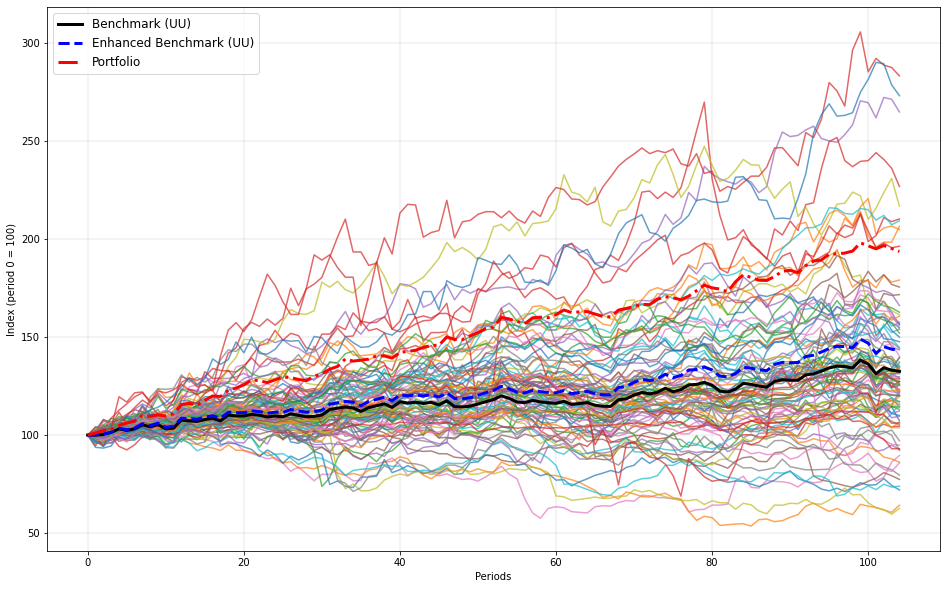

In [527]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = np.concatenate((np.zeros((1, N)), Assets), axis=0);
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 300], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(Index);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = np.insert(intermediateIndex, 0, 1.0, axis=0) * 100;
ax.plot(index, label="Benchmark ({})".format(whichData), linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot alphaIndex
intermediateIndex = np.transpose(indexAlpha);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = np.insert(intermediateIndex, 0, 1.0, axis=0) * 100;
ax.plot(index, label="Enhanced Benchmark ({})".format(whichData), linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label="Portfolio".format(whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)


# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

## Out-of-Sample Testing (DD)

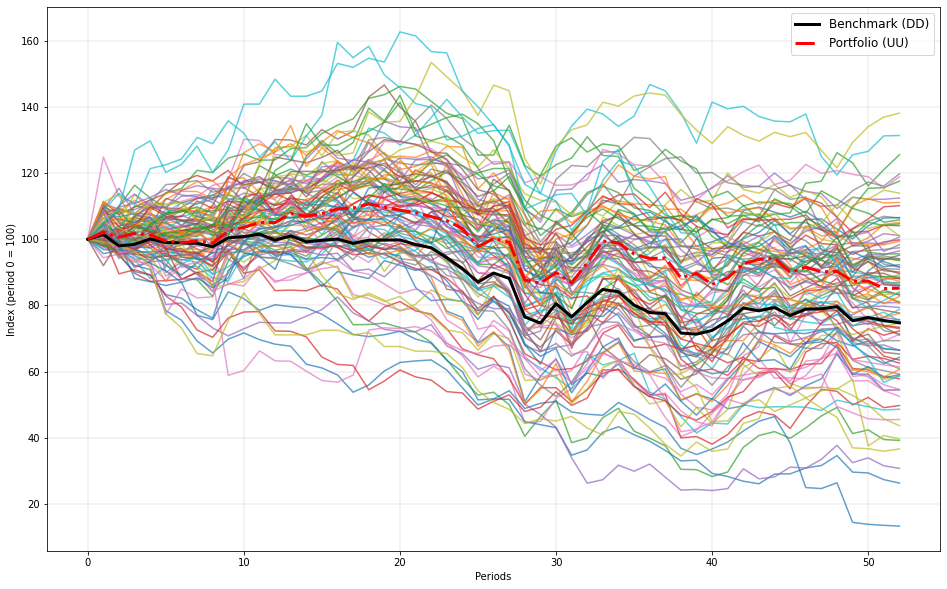

In [528]:
# Portfolio
portfolio = np.matmul(AssetsOoS, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label="Portfolio ({})".format(whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

## Out-of-Sample Testing (DU)

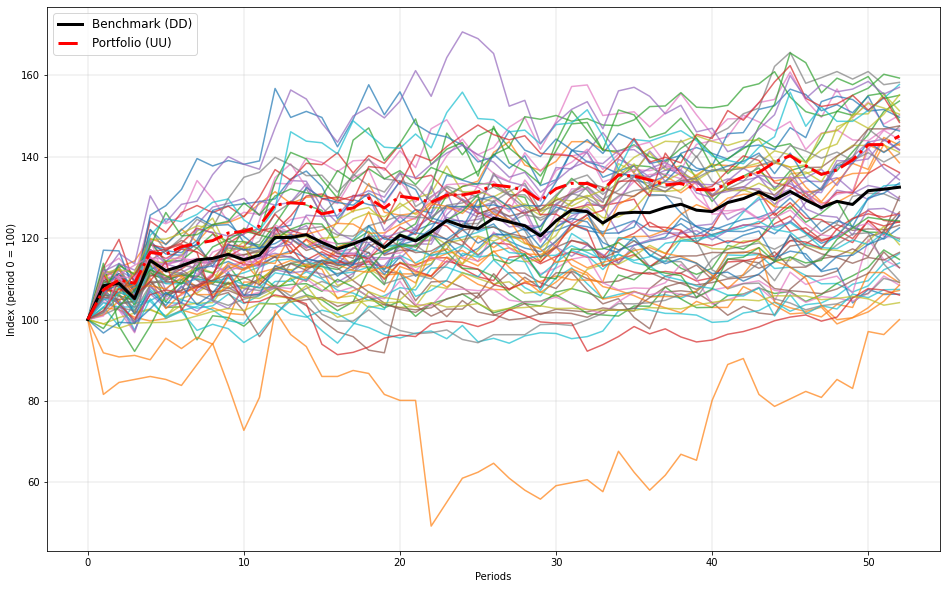

In [529]:
# Portfolio
portfolio = np.matmul(AssetsOoS1, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS1;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS1);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label="Portfolio ({})".format(whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

## Out-of-Sample Testing (UD)

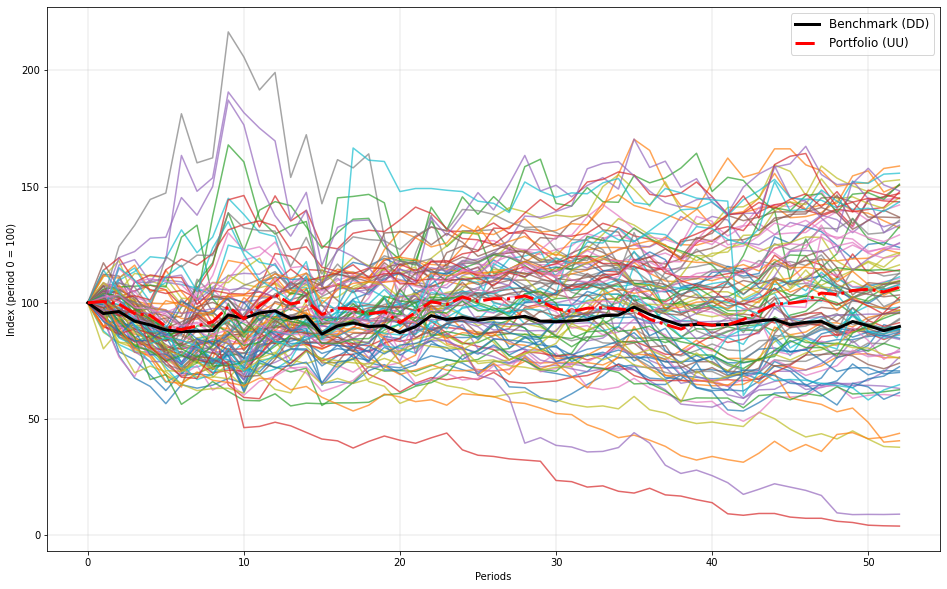

In [530]:
# Portfolio
portfolio = np.matmul(AssetsOoS2, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS2;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS2);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label="Portfolio ({})".format(whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

## Out-of-Sample Testing (UU)

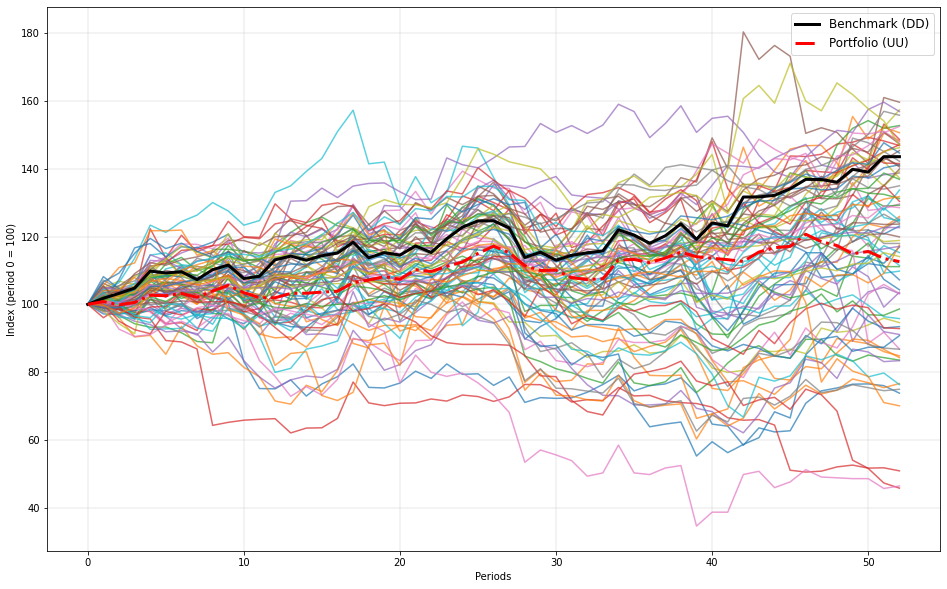

In [531]:
# Portfolio
portfolio = np.matmul(AssetsOoS3, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS3;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS3);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label="Portfolio ({})".format(whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()